In [5]:
import os
import time
import h5py
import cv2
from collections import Counter
from collections import OrderedDict
from collections import defaultdict
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from skimage.segmentation import find_boundaries
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.util import montage

from utils import quick_stats
from utils import rle_encode
from utils import rle_decode
from utils import rle_to_inner_masks
from utils import rle_to_stacked_masks
from utils import read_stacked_masks
from utils import masks_as_image
from utils import get_gaussian_mask

%matplotlib inline
%reload_ext autoreload
%autoreload 2

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
montage_pad = lambda x, *args, **kwargs: montage(x, padding_width=10, *args, **kwargs)
MASK_METHOD = 'fullmasks'
CROP_SIZE = 384
ship_dir = "/media/Borg_LS/DATA/geos/airbus/input/"
train_image_dir = os.path.join(ship_dir, 'train_768')
train_chip_dir = os.path.join(ship_dir, f"train_{CROP_SIZE}")
train_mask_dir = os.path.join(ship_dir, f"train_masks_{CROP_SIZE}")
train_mask_file = os.path.join(ship_dir, 'train_ship_segmentations_v2.csv')
clean_mask_file = os.path.join(ship_dir, "train_ship_segmentations_v2_cleaned.csv")
train_ship_filename2 = os.path.join(ship_dir, "train_ship_segmentations2.csv")
chip_meta_file_name = os.path.join(ship_dir, f"{MASK_METHOD}_{CROP_SIZE}_all.csv")
h5_file = os.path.join(ship_dir, f"{MASK_METHOD}_{CROP_SIZE}.h5")
chip_file_name = os.path.join(ship_dir, f"{MASK_METHOD}_{CROP_SIZE}.csv")

Merge the old test set with the training set

In [54]:
# masks_train = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations.csv'))
# masks_test = pd.read_csv(os.path.join(ship_dir, 'test_ship_segmentations.csv'))
# df = pd.concat([masks_train, masks_test])
# df = df.sort_values(by=['ImageId']) 
# df = df.reset_index(drop=True)
# df.head()

In [7]:
df = pd.read_csv(train_mask_file)
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [3]:
# ignore_from_testing = [
#     '13703f040.jpg', '14715c06d.jpg',
#     '33e0ff2d5.jpg', '4d4e09f2a.jpg',
#     '877691df8.jpg', '8b909bb20.jpg',
#     'a8d99130e.jpg', 'ad55c3143.jpg',
#     'c8260c541.jpg', 'd6c7f17c7.jpg',
#     'dc3e7c901.jpg', 'e44dffe88.jpg',
#     'ef87bad36.jpg', 'f083256d8.jpg'
# ]
    
bad_overlap = [
    '080e90ed4.jpg', '09cdee15d.jpg',
    '045266ab5.jpg', '0ae4c0a90.jpg',
    '1081543bd.jpg', '1132e53d6.jpg', 
    '115ae517e.jpg', '170e28656.jpg', 
    '19dedd4b3.jpg', '1aa4e2722.jpg',
    '25b3d35ed.jpg', '26b98510b.jpg',
    '29054f7f3.jpg', '2d852e671.jpg', 
    '2a7bf5bfa.jpg', '374ef5a58.jpg',
    '3985ecd2e.jpg', '41243acda.jpg',
    '4390a9651.jpg', '461f9e3e6.jpg',
    '483db9252.jpg', '4ccc356e8.jpg', 
    '54604a0a5.jpg', '5676dac91.jpg', 
    '6143585a2.jpg', '6f4bac38d.jpg',
    '71e95d7e3.jpg', '7db36f616.jpg', 
    '8432013c3.jpg', '8527570c9.jpg', 
    '9edef8ed8.jpg', 'aab4c6e79.jpg', 
    'acf827496.jpg', 'b96a76ee3.jpg', 
    'c3633dc37.jpg', 'c3f74eefd.jpg', 
    'c6e354b2c.jpg', 'ebc35d891.jpg'
]

missing = [
    '02f05f1f2.jpg', '0adc9c314.jpg', 
    '107dc1bc4.jpg', '16a177779.jpg', 
    '1bf4e1ad0.jpg', '1f2b9db59.jpg', 
    '20026b562.jpg', '2311cbbc1.jpg', 
    '298554c67.jpg', '3df2944be.jpg', 
    '45430a7cb.jpg', '4714883c2.jpg', 
    '48bcbbac2.jpg', '4c9abe128.jpg', 
    '55e3bb006.jpg', '562494567.jpg', 
    '58809225d.jpg', '61b77138e.jpg', 
    '63fbc7c24.jpg', '77ac609be.jpg', 
    '827238dc5.jpg', '8b86f5e6d.jpg', 
    '8cc68b7ea.jpg', '8e1c62ec9.jpg',
    '935dc143c.jpg', '9655d9822.jpg', 
    'c2c5c5529.jpg', 'd27632e9b.jpg', 
    'd6f5a3f16.jpg', 'dc50a2510.jpg', 
    'ddad8ae16.jpg', 'e74dcde3b.jpg', 
    'ea038cf94.jpg', 'fdb45f7c8.jpg'
]

In [ ]:
# removed from fullmasks_768_down_384.csv
missing_ship_segs = [
    '0413cfbde.jpg',
    '5ec1c059c.jpg',
    '83feab955.jpg',
    '8da52e22a.jpg',
    '943714d8d.jpg',
    '98831afc3.jpg',
    'aa23075df.jpg',
    'b867b6b13.jpg',
    'c5d17f449.jpg',
    'd4b608de9.jpg',
    'ed60f9a34.jpg',
    'f6be9391b.jpg',
    'ffaf289fa.jpg']

# removed from fullmasks_768.csv
missing_segs = [
    '00c996565.jpg', 
    '0413cfbde.jpg',
    '0ba05ff78.jpg', 
    '12e4c5d17.jpg',
    '2ec6bf169.jpg', 
    '34ae97f8a.jpg', 
    '353721cd2.jpg',
    '3e0086c9e.jpg',
    '4bfc4cc05.jpg', 
    '4e57b304a.jpg', 
    '5ec1c059c.jpg',
    '6666baaff.jpg',
    '60c61353d.jpg',
    '7f5181705.jpg',
    '7f99283ba.jpg', 
    '83feab955.jpg', 
    '848ae9a1d.jpg',
    '8da52e22a.jpg', 
    '9199bec4b.jpg',
    '91c9095d0.jpg',
    '943714d8d.jpg', 
    '97e862924.jpg', 
    '98831afc3.jpg',
    '990bffcd6.jpg',
    'aa23075df.jpg', 
    'b22150e77.jpg',
    'b867b6b13.jpg',
    'ba6e404b7.jpg', 
    'ce969af76.jpg',
    'd162a097f.jpg', 
    'd4b608de9.jpg',
    'd570b3baf.jpg', 
    'd88773293.jpg', 
    'de729d58d.jpg', 
    'e12589a11.jpg', 
    'f24bf4c7d.jpg', 
    'f2a11fc7e.jpg',
    'ffaf289fa.jpg', 
    'ff2ba78bb.jpg',
]

In [5]:
f2_lt_06 = [
    '00021ddc3.jpg', '00031f145.jpg', '002c78530.jpg', '00be4edfb.jpg', 
    '010cbbfa0.jpg', '0163c7069.jpg', '017a3a722.jpg', '019c45bdf.jpg', 
    '01a26b0b2.jpg', '01b04ce8d.jpg', '0210c65fa.jpg', '02224f66f.jpg', 
    '0253c3406.jpg', '025b52a2b.jpg', '0296e8724.jpg', '03dc71fb4.jpg', 
    '04070d798.jpg', '041577100.jpg', '043d8815e.jpg', '0471e6fa0.jpg', 
    '04a9e3a9a.jpg', '04d3d8d17.jpg', '05131f45f.jpg', '055baa095.jpg', 
    '05681e655.jpg', '05b3b9b70.jpg', '05bbed8e3.jpg', '05e37904a.jpg', 
    '06145c246.jpg', '0624ddeef.jpg', '0678d581b.jpg', '07239f63c.jpg', 
    '07bf99262.jpg', '07c76ec1d.jpg', '07c7d0f65.jpg', '080d9ae0e.jpg', 
    '0885c1026.jpg', '08ec53f2a.jpg', '08ff69841.jpg', '097e21dfe.jpg', 
    '0a9eca6d6.jpg', '0be9c88d0.jpg', '0bf5a6b3e.jpg', '0c10c2d10.jpg', 
    '0c2f418ae.jpg', '0ca8e79b5.jpg', '0cbee494c.jpg', '0cf6a999d.jpg', 
    '0d85d118e.jpg', '0d8c8a186.jpg', '0debfe752.jpg', '0ed60a1e4.jpg', 
    '0ee9ba19a.jpg', '0eecbd1be.jpg', '0f2be3317.jpg', '0f82e2f00.jpg', 
    '0fa355c77.jpg', '0fa4ddf64.jpg', '0ff78100d.jpg', '1003ef610.jpg', 
    '1070e88fd.jpg', '10c1089fd.jpg', '10cb62c77.jpg', '10f153420.jpg', 
    '10f9072db.jpg', '1196a0e1a.jpg', '121715e53.jpg', '1349f14c3.jpg', 
    '14349e164.jpg', '150de0cbc.jpg', '152411fdc.jpg', '1541fc93d.jpg', 
    '1577c0fcd.jpg', '158bf31e1.jpg', '158d61c0a.jpg', '15fc0a3ff.jpg', 
    '16b10616e.jpg', '1721f5d2f.jpg', '1740ebfbe.jpg', '178114eca.jpg', 
    '17bcad4c8.jpg', '17ce75159.jpg', '18f538988.jpg', '1908aba09.jpg', 
    '1b1d2cb5b.jpg', '1b6808b6b.jpg', '1bfabb948.jpg', '1c4696ab5.jpg', 
    '1c4a67c4e.jpg', '1c7b36b20.jpg', '1d19286db.jpg', '1d43e9000.jpg', 
    '1d7a6fcf6.jpg', '1d9868e37.jpg', '1e3aefd36.jpg', '1e660d96a.jpg', 
    '1f5646c98.jpg', '1f6a3b3ca.jpg', '1fbabbc52.jpg', '1fd9f7f15.jpg', 
    '20147bcb0.jpg', '2015fc0b4.jpg', '20699e16a.jpg', '206fa123f.jpg', 
    '20787cb54.jpg', '21ab7a992.jpg', '21e13e0e8.jpg', '21fbda3ac.jpg', 
    '2220a8113.jpg', '22789e87b.jpg', '2357d14b9.jpg', '23b290913.jpg', 
    '23e6b4cdd.jpg', '23fba4cea.jpg', '24a47a371.jpg', '24e7b6fb0.jpg', 
    '24fefb314.jpg', '252fb3868.jpg', '2531669aa.jpg', '2659f9ad9.jpg', 
    '26694a547.jpg', '26fa001e4.jpg', '2711da9e1.jpg', '27ac739d8.jpg', 
    '27c138f0b.jpg', '286ed3308.jpg', '28f9b827d.jpg', '29941f9c1.jpg', 
    '2a668a742.jpg', '2abf0e31b.jpg', '2b194349d.jpg', '2b1cf9ceb.jpg', 
    '2cf06799f.jpg', '2d0d72a0c.jpg', '2d6923fa6.jpg', '2d8983ec5.jpg', 
    '2de36504a.jpg', '2e14834f3.jpg', '2e18b75c3.jpg', '2f4622ab6.jpg', 
    '2f584374b.jpg', '2f8be74f6.jpg', '2fb2ee6a5.jpg', '2fdbedcf2.jpg', 
    '2fe63d991.jpg', '302d2e599.jpg', '306770eaa.jpg', '30d8cfdad.jpg', 
    '319d89dea.jpg', '31eb98036.jpg', '327fe2a43.jpg', '32a44f9e0.jpg', 
    '32c4af794.jpg', '32f06ed37.jpg', '332556767.jpg', '338842e8f.jpg', 
    '33e2610ad.jpg', '3401b0227.jpg', '344264508.jpg', '351e8310c.jpg', 
    '35cf928eb.jpg', '3618853e6.jpg', '365c47e26.jpg', '37c8d9ba2.jpg', 
    '3814cd502.jpg', '3818abe8a.jpg', '38e84096e.jpg', '395856098.jpg', 
    '397d8e801.jpg', '3a4ce6532.jpg', '3ad930e6c.jpg', '3bac02f61.jpg', 
    '3bb4d1347.jpg', '3dccdebd0.jpg', '3e2cc4fe7.jpg', '3e61838ce.jpg', 
    '3eed251eb.jpg', '3ef1d847b.jpg', '3f0200ae5.jpg', '3f3cd3f11.jpg', 
    '3f523d5c1.jpg', '3f9440a5c.jpg', '3ff2e23f0.jpg', '40daa01b0.jpg', 
    '412276aeb.jpg', '42104086d.jpg', '42bee6533.jpg', '42e7ce24b.jpg', 
    '42f272b67.jpg', '42fdcd5f6.jpg', '43ae8a9ec.jpg', '443397fd0.jpg', 
    '444bcc889.jpg', '44b9b1a20.jpg', '451228941.jpg', '451506b24.jpg', 
    '459a3329d.jpg', '46acc6642.jpg', '479a64c50.jpg', '47cb21229.jpg', 
    '485dfe0b0.jpg', '48d3f4b27.jpg', '4958a7963.jpg', '498f7c4a6.jpg', 
    '49ac07665.jpg', '4a016f345.jpg', '4a2d0a8fc.jpg', '4ad526af6.jpg', 
    '4af54b7ce.jpg', '4b6dfbe84.jpg', '4b8137d3a.jpg', '4b8247da6.jpg', 
    '4bf2a8cbc.jpg', '4c0bd0e57.jpg', '4cb1fb236.jpg', '4d1ba5d50.jpg', 
    '4d33035cd.jpg', '4d8e72911.jpg', '4dbcac98d.jpg', '4e5a4c872.jpg', 
    '4f4112455.jpg', '4f7d0e2fb.jpg', '4fe631d47.jpg', '5081b2921.jpg', 
    '50d17b704.jpg', '50dcd628f.jpg', '516d46bb7.jpg', '51c7923fe.jpg', 
    '5293bc60d.jpg', '53233e274.jpg', '535cc00b6.jpg', '53b4ca865.jpg', 
    '53fdf0fff.jpg', '54304dff0.jpg', '547a74c6f.jpg', '54d11a68d.jpg', 
    '558bf7611.jpg', '55b3a99ba.jpg', '561beab4a.jpg', '5685be8ad.jpg', 
    '5787c6361.jpg', '57d876f1b.jpg', '588f52792.jpg', '58cde1edb.jpg', 
    '594299435.jpg', '5a3027d50.jpg', '5c011acd6.jpg', '5d0018daf.jpg', 
    '5e2181ac2.jpg', '5f1f00d60.jpg', '5f3948811.jpg', '5f8ee9daf.jpg', 
    '600532ae9.jpg', '600833ea7.jpg', '600bfedf2.jpg', '604b98194.jpg', 
    '6086bcb3a.jpg', '619975dba.jpg', '619b781c2.jpg', '61b63d0b4.jpg', 
    '61d1c4a35.jpg', '61f6d8d8f.jpg', '6206a7b0c.jpg', '62b1f6be2.jpg', 
    '62f028c4b.jpg', '6386110bc.jpg', '63ec00603.jpg', '64f6200f7.jpg', 
    '654b34825.jpg', '661e66ecd.jpg', '681a71969.jpg', '6863f209d.jpg', 
    '6903d026d.jpg', '6a911621f.jpg', '6c222d61f.jpg', '6c8570a06.jpg', 
    '6cc34bb44.jpg', '6deb46494.jpg', '6f3e6c5b6.jpg', '706cb7d96.jpg', 
    '7137d1f55.jpg', '7281cdecb.jpg', '72c3a9933.jpg', '73122cca0.jpg', 
    '73361816c.jpg', '73dba17a6.jpg', '7437feca3.jpg', '754326edc.jpg', 
    '7567b173a.jpg', '75aa27a43.jpg', '75f275152.jpg', '762bfb6ea.jpg', 
    '76e0fee05.jpg', '76ef61551.jpg', '7746366c7.jpg', '77da4116e.jpg', 
    '78d9a85d1.jpg', '7a2145550.jpg', '7af315cfe.jpg', '7bd9aec18.jpg', 
    '7c383a06e.jpg', '7d1333b73.jpg', '7d73acb15.jpg', '7e19bbc46.jpg', 
    '7ea8fe197.jpg', '7ecee4e42.jpg', '7fd79ab5f.jpg', '817396702.jpg', 
    '82a521559.jpg', '837985e49.jpg', '838ee8970.jpg', '83aa4ce47.jpg', 
    '84feb6c06.jpg', '851ccf864.jpg', '85859a55f.jpg', '85c0e41be.jpg', 
    '85c4328bf.jpg', '860be5ac8.jpg', '868d56037.jpg', '869481515.jpg', 
    '86ab5828b.jpg', '86e698a63.jpg', '8904c6b35.jpg', '8a3977099.jpg', 
    '8a9df2705.jpg', '8aaffa416.jpg', '8b06b56e4.jpg', '8b4d5572c.jpg', 
    '8bfe84d3e.jpg', '8ca19571e.jpg', '8d2c932bc.jpg', '8d998e90f.jpg', 
    '8ddbac493.jpg', '8dfcc9a22.jpg', '8e4a4871a.jpg', '8e88ab35f.jpg', 
    '8fdffa16f.jpg', '904215479.jpg', '9092c6219.jpg', '90fde558d.jpg', 
    '915dac3f3.jpg', '92ff29888.jpg', '930a062e3.jpg', '931a89ac1.jpg', 
    '939d31d0e.jpg', '93b499e66.jpg', '93d183f88.jpg', '943384c23.jpg', 
    '960514723.jpg', '966c3c547.jpg', '96882d81d.jpg', '96edddec9.jpg', 
    '970adc47f.jpg', '97a161e98.jpg', '97c4aab79.jpg', '98ecb1672.jpg', 
    '992eec1d0.jpg', '997663356.jpg', '997cc6536.jpg', '9a24c0c53.jpg', 
    '9a4260c4e.jpg', '9bd8fd049.jpg', '9c38ae589.jpg', '9e63236d2.jpg', 
    '9ea36ab90.jpg', '9ed0c3939.jpg', 'a05e60741.jpg', 'a2c1272a6.jpg', 
    'a40c4ba87.jpg', 'a65ea6bbd.jpg', 'a68534fce.jpg', 'a6c3e449e.jpg', 
    'a70e12d84.jpg', 'a7288a7e4.jpg', 'a731dc654.jpg', 'a802ccbbc.jpg', 
    'a83e15541.jpg', 'aa35e3eda.jpg', 'aa38f954f.jpg', 'aaae9b635.jpg', 
    'aba2ef0f5.jpg', 'ac11f1e97.jpg', 'ac2d2554e.jpg', 'ac5d29a06.jpg', 
    'ac891abaa.jpg', 'acb3b1d2e.jpg', 'acc7e78a9.jpg', 'ae5ffe012.jpg', 
    'af8c3eaec.jpg', 'b22e2f206.jpg', 'b2faafb1a.jpg', 'b34b03955.jpg', 
    'b37236000.jpg', 'b37c9e2e2.jpg', 'b4e14fed3.jpg', 'b4ee31d2a.jpg', 
    'b73cf5b00.jpg', 'b77d578d4.jpg', 'b7fc5166b.jpg', 'b83d1c450.jpg', 
    'b85c9f739.jpg', 'b869e6228.jpg', 'b8a9b3d10.jpg', 'b991098c7.jpg', 
    'bbea210f1.jpg', 'bc62e2c88.jpg', 'bd0bec6fb.jpg', 'bd22a6316.jpg', 
    'beb971be7.jpg', 'c0d1360a3.jpg', 'c20b78352.jpg', 'c3a6d70b0.jpg', 
    'c4a3a677d.jpg', 'c5ed9fb3a.jpg', 'c7411048d.jpg', 'c76a69792.jpg', 
    'c7bb490ad.jpg', 'c8327dd2e.jpg', 'ca1eeca1e.jpg', 'ca78eac88.jpg', 
    'cbb259ca5.jpg', 'cd4d4e12d.jpg', 'ce4ebc72c.jpg', 'cf003f32f.jpg', 
    'cf250db7a.jpg', 'd00b07bb2.jpg', 'd2c411541.jpg', 'd382a15fb.jpg', 
    'd3b31d204.jpg', 'd40ca9dda.jpg', 'd46191fbc.jpg', 'd65f9650b.jpg', 
    'd8aebffce.jpg', 'd954a2b84.jpg', 'd9b9be0af.jpg', 'dab8b363c.jpg', 
    'dcbed4e91.jpg', 'de4438748.jpg', 'dffc000db.jpg', 'e0ffa17d8.jpg', 
    'e1352a6d8.jpg', 'e13c9dfd7.jpg', 'e25754987.jpg', 'e2615fb70.jpg', 
    'e422d20fa.jpg', 'e44ff18ea.jpg', 'e5071edd6.jpg', 'e6961a3b8.jpg', 
    'e6b6a2ee4.jpg', 'e6f9edeeb.jpg', 'e9113a042.jpg', 'e9548e98e.jpg', 
    'ea9f82665.jpg', 'eb45bf420.jpg', 'eba4dd925.jpg', 'ee454b081.jpg', 
    'f073dd78b.jpg', 'f3cbca9b6.jpg', 'f40360970.jpg', 'f4c146241.jpg', 
    'f52d023a8.jpg', 'f6151a638.jpg', 'f66cb3080.jpg', 'f7a17d65a.jpg', 
    'f891e184c.jpg', 'fada39cd3.jpg', 'fbb37cf44.jpg', 'fc8c70b1e.jpg', 
    'fd1dd9e61.jpg', 'fd1de824c.jpg', 'fdc7cce80.jpg', 'fdf72e203.jpg', 
    'ff61e3c0d.jpg', 'ff7ac7f3c.jpg', 'ff9a9fb1a.jpg']


low_res = [
    '3d2261d51.jpg', '4a14ec421.jpg', 
    '540bd9b94.jpg', '63ac08f8b.jpg', 
    '644483028.jpg', '649aaf688.jpg', '6bf2aa0b7.jpg',
    '8772f587d.jpg', '8cbffb64a.jpg', 
    '8e0cc7b1a.jpg', '90d34f8ee.jpg', '952940543.jpg',
    'a6f4088f8.jpg', 'b0f7abbe8.jpg', 'b82d750d8.jpg', 
    'bbf30574e.jpg', 'ccdab9431.jpg', 'd5f9342c7.jpg', 
    'd8e1291a9.jpg', 'e8d21cb6c.jpg', 'f8339e72f.jpg']

bg_with_ships = [
    '1f94f524a.jpg',
    '2556c121c.jpg',
    '2a1053349.jpg',
    '35ea0734e.jpg',
    '3725e46f7.jpg',
    '4649100f0.jpg',
    '4d2e2d3c2.jpg',
    '5a3796ae3.jpg',
    '5d4bdfbe1.jpg',
    '5d97d8b7e.jpg',
    '64e38074b.jpg',
    '73fffb68b.jpg',
    '99df3c6f7.jpg',
    '9b87ff33f.jpg',
    'cc149f2dc.jpg',
    'ed656dd42.jpg',
    'f8491930c.jpg'
]

In [8]:
print(df.shape[0], 'masks before')

# for cid in ignore_from_testing:
#     if cid in df['ImageId'].values:
#         df = df[df['ImageId'] != cid]
#     else:
#         print(cid, f'not found. {cid}, (ignore_from_testing)')
        
for cid in bad_overlap:
    if cid in df['ImageId'].values:
        df = df[df['ImageId'] != cid]
    else:
        print(cid, f'not found. {cid}, (bad_overlap)')
    
for cid in missing:
    if cid in df['ImageId'].values:
        df = df[df['ImageId'] != cid]
    else:
        print(cid, f'not found. {cid}, (missing)')
    
for cid in f2_lt_06:
    if cid in df['ImageId'].values:
        df = df[df['ImageId'] != cid]
    else:
        print(cid, f'not found. {cid}, (bad_f2)')
    
for cid in low_res:
    if cid in df['ImageId'].values:
        df = df[df['ImageId'] != cid]
    else:
        print(cid, f'not found. {cid}, (low_res)')
    
for cid in bg_with_ships:
    if cid in df['ImageId'].values:
        df = df[df['ImageId'] != cid]
    else:
        print(cid, f'not found. {cid}, (background_with_ships)')
        
df = df[df['ImageId'] != '6384c3e78.jpg']
# df = df.drop('6384c3e78.jpg', axis=0)
# df = df.reset_index()

print(df.shape[0], 'masks after')
print(df['ImageId'].value_counts().shape[0])

df.to_csv(clean_mask_file, index=False)
df.head()

231723 masks before
229696 masks after
191987


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [9]:
masks = pd.read_csv(clean_mask_file)
# masks = masks.dropna()
masks.head()

unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
masks = pd.merge(masks, unique_img_ids)
masks['counts'] = masks.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

229696 masks found
191987


,ImageId,EncodedPixels,counts
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5


In [10]:
masks = masks[masks['counts'] >= 1]
masks.shape[0]

79697

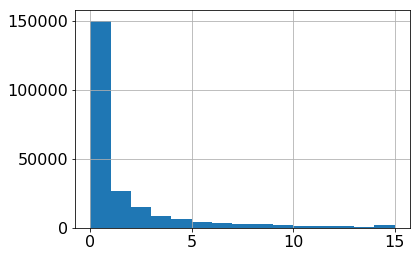

In [12]:
masks['counts'].hist(bins=masks['counts'].max());

In [ ]:
masks['counts'].hist(bins=(masks['counts'].max()-masks['counts'].min()));

In [ ]:
masks.groupby(['counts']).size()

In [12]:
masks.head()

,ImageId,EncodedPixels,counts
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,5
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,5


In [14]:
x_max0 = 0
y_max0 = 0
a_max0 = 0
# all_img_ids = []
# all_seg_cts = []
n_pixels = defaultdict()
x_mins = defaultdict()
x_maxs = defaultdict()
y_mins = defaultdict()
y_maxs = defaultdict()
heights = defaultdict()
widths = defaultdict()
areas = defaultdict()
ship_length = defaultdict()

for idx, (c_img_id, rle_mask, cnt) in masks.iterrows():
    ship_mask = rle_decode(rle_mask)
    ship_idxs = np.where(ship_mask >= 0.5)
    n_pixels[idx] = len(ship_idxs[0])
    
    y_min = np.min(ship_idxs[0])
    y_max = np.max(ship_idxs[0])
    height = 1 + y_max - y_min
    y_mins[idx] = y_min
    y_maxs[idx] = y_max
    heights[idx] = height
    
    x_min = np.min(ship_idxs[1])
    x_max = np.max(ship_idxs[1])
    width = 1 + x_max - x_min
    x_mins[idx] = x_min
    x_maxs[idx] = x_max
    widths[idx] = width
    ship_length[idx] = int(np.sqrt(width**2 + height**2))
    
    a_size = width * height
    areas[idx] = a_size
    if width > x_max0:
        x_max0 = width
        x_max_id = c_img_id
        print(f'{idx:>5} x  ', x_max_id, f'{cnt:>3}', x_max0)
    if height > y_max0:
        y_max0 = height
        y_max_id = c_img_id
        print(f'{idx:>5}  y ', y_max_id, f'{cnt:>3}', y_max0)
    if a_size > a_max0:
        a_max0 = a_size
        a_max_id = c_img_id
        print(f'{idx:>5}   a', a_max_id, f'{cnt:>3}', a_max0)

print('y_max', y_max_id, y_max)
print('x_max', x_max_id, x_max)

    2   y 000155de5.jpg   1 36
    2  x  000155de5.jpg   1 104
    2 a   000155de5.jpg   1 3744
   19   y 0005d01c8.jpg   2 141
   19  x  0005d01c8.jpg   2 165
   19 a   0005d01c8.jpg   2 23265
   22   y 0006c52e8.jpg   1 275
   22  x  0006c52e8.jpg   1 217
   22 a   0006c52e8.jpg   1 59675
   83  x  0018e5d6c.jpg   1 283
  108  x  001ed8b9b.jpg   1 330
 1008 a   013048d62.jpg   4 63279
 4349   y 04dcb931f.jpg   4 291
 4510  x  050724be2.jpg   1 334
 4969  x  0586cc7eb.jpg   2 358
 6135   y 06dd3e135.jpg   2 293
 6135 a   06dd3e135.jpg   2 65925
10696  x  0bc4a43a9.jpg   1 391
11256 a   0c6b7bca1.jpg   1 70848
11996  x  0d4704282.jpg   2 444
14241   y 0fd84d04a.jpg  10 309
14615 a   1047ce31c.jpg   1 71544
20331   y 16cc1c322.jpg   2 311
26606   y 1de00ba41.jpg   2 319
28276 a   1fd8c725c.jpg   1 77558
47446   y 357acae07.jpg   3 335
y_max 357acae07.jpg 311
x_max 0d4704282.jpg 606


In [15]:
masks['x_min'] = pd.Series(x_mins)
masks['x_max'] = pd.Series(x_maxs)
masks['y_min'] = pd.Series(y_mins)
masks['y_max'] = pd.Series(y_maxs)

masks['height'] = pd.Series(heights)
masks['width'] = pd.Series(widths)
masks['area'] = pd.Series(areas)
masks['n_pixels'] = pd.Series(n_pixels)
masks['ship_length'] = pd.Series(ship_length)

In [16]:
masks.to_csv(train_ship_filename2, index=False)

In [2]:
masks = pd.read_csv(train_ship_filename2)
print(len(masks))
masks.head()

79697


,ImageId,EncodedPixels,counts,x_min,x_max,y_min,y_max,height,width,area,n_pixels,ship_length
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,344,447,465,500,36,104,3744,3388,110
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5,469,491,287,306,20,23,460,177,30
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5,67,84,377,385,9,18,162,148,20
3,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,5,258,305,174,184,11,48,528,480,49
4,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,5,72,78,386,386,1,7,7,7,7


In [11]:
masks.describe(percentiles=[0.01, 0.05, .25, .5, .75, 0.95, 0.99])

,counts
count,79697.000000
mean,3.734331
std,3.420410
min,1.000000
1%,1.000000
5%,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
95%,12.000000


In [ ]:
ImageId = '000194a2d.jpg'
img = imread(os.path.join(train_chip_dir, ImageId))
# img = cv2.imread(os.path.join(train_chip_dir, ImageId))
in_mask_list = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

merged_masks = np.zeros((768, 768), dtype=int)
for i, mask in enumerate(in_mask_list):
    merged_masks += (rle_decode(mask) * (i+1))

fig, axarr = plt.subplots(1, 2, figsize=(15, 40))
axarr[0].imshow(img)
axarr[1].imshow(merged_masks)

In [ ]:
print(mask)
print(rle_encode(rle_decode(mask)))

In [ ]:
masks['ship_length'].hist(bins=300);

In [ ]:
def get_record_weights(img, seg, img_gaussian_mask, seg_gaussian_mask):
    img_diff = img - np.mean(img, axis=(0, 1))
    xg = np.sqrt(np.sum(np.sum(np.square(img_diff), axis=-1) * img_gaussian_mask))
    yg = np.sqrt(np.sum(np.sum(seg, axis=-1) * seg_gaussian_mask))
    return xg + yg

In [ ]:
img_gaussian_mask = get_gaussian_mask((CROP_SIZE, CROP_SIZE), scale=0.1, sigma=1.5)
seg_gaussian_mask = get_gaussian_mask((CROP_SIZE, CROP_SIZE), sigma=1.5)

In [20]:
mask_h5.close()

In [13]:
all_batches = list(masks.groupby('ImageId'))

In [ ]:
jj = 0
done = False
for c_img_id, c_masks in all_batches:
    ii = 0
    for idx, mask_meta in c_masks.iterrows():
        ii += 1
        if jj != idx:
            print('jj', jj, 'idx', idx)
        if jj % 9000 == 0:
            print(jj, idx, c_img_id)
        jj += 1

In [4]:
t0 = time.time()
t1 = time.time()
new_img_ids = defaultdict()
# record_weights = defaultdict()
n_pixels = defaultdict(int)
r_mean = defaultdict(int)
g_mean = defaultdict(int)
b_mean = defaultdict(int)
r_std = defaultdict(int)
g_std = defaultdict(int)
b_std = defaultdict(int)
x_mins = defaultdict(int)
x_maxs = defaultdict(int)
y_mins = defaultdict(int)
y_maxs = defaultdict(int)
heights = defaultdict(int)
widths = defaultdict(int)
areas = defaultdict(int)
ship_length = defaultdict(int)

os.makedirs(train_chip_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)

offset = CROP_SIZE // 2
with h5py.File(h5_file, 'w') as mask_h5:
    for c_img_id, c_masks in all_batches:
#         in_image = cv2.imread(os.path.join(train_image_dir, c_img_id))
#         in_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2RGB)
            
        if MASK_METHOD == 'innermasks':
            in_masks = rle_to_inner_masks(c_masks['EncodedPixels'].values)
        elif MASK_METHOD == 'fullmasks':
            in_masks = rle_to_stacked_masks(c_masks['EncodedPixels'].values)
        
        in_mask = np.sum(in_masks, axis=0).astype(np.bool)
        
#         cv2.imwrite(os.path.join(train_mask_dir, c_img_id), in_mask * 255)
#         crop_mask = np.expand_dims(in_mask, -1) # shortcut for 768 database
#         mask_h5.create_dataset(c_img_id, data=crop_mask) 
#         continue
        
        filebase, fileext = c_img_id.split('.')
        ii = -1
        for idx, mask_meta in c_masks.iterrows():
            ii += 1
            i_img_id = f'{filebase}_{ii+1}.{fileext}'
            i_msk_id = f'{filebase}/{ii+1}.{fileext}'

            y_mid = (mask_meta.y_min + mask_meta.y_max) // 2
            if y_mid < offset:
                # Top Border
#                 y = 0
                continue
            elif y_mid > in_mask.shape[0] - offset:
                # Bottom Border
#                 y = in_mask.shape[0] - CROP_SIZE
                continue
            else:
                y = y_mid - offset

            x_mid = (mask_meta.x_min + mask_meta.x_max) // 2
            if x_mid < offset:
                # Left Border
#                 x = 0
                continue
            elif x_mid > in_mask.shape[1] - offset:
                # Right Border
#                 x = in_mask.shape[1] - CROP_SIZE
                continue
            else:
                x = x_mid - offset

            crop_ship_mask = in_masks[ii, y:y + CROP_SIZE, x:x + CROP_SIZE]
            assert crop_ship_mask.shape == (CROP_SIZE, CROP_SIZE)
            ship_idxs = np.where(crop_ship_mask >= 0.5)

            if len(ship_idxs[0]) <= 9: # leave out tiny ships
                continue

#             y_min = np.min(ship_idxs[0])
#             y_max = np.max(ship_idxs[0])
#             x_min = np.min(ship_idxs[1])
#             x_max = np.max(ship_idxs[1])
#             y_size = 1 + y_max - y_min
#             x_size = 1 + x_max - x_min

            # everything looks good so save the cropped image, append the cropped mask to the database,
            # and append stats.
            
#             crop_image = in_image[y:y + CROP_SIZE, x:x + CROP_SIZE, :]
#             if crop_image.shape != (CROP_SIZE, CROP_SIZE, 3):
#                 print(idx, i_img_id, crop_image.shape)
#             cv2.imwrite(os.path.join(train_chip_dir, i_img_id), crop_image)
            
#             r0, g0, b0 = np.mean(crop_image, axis=(0, 1))
#             r1, g1, b1 = np.std(crop_image, axis=(0, 1))

            crop_mask = in_mask[y:y + CROP_SIZE, x:x + CROP_SIZE]
#             cv2.imwrite(os.path.join(train_mask_dir, i_img_id), crop_mask * 255)

            crop_mask = np.expand_dims(crop_mask, -1)
            assert len(crop_mask.shape) == 3
            mask_h5.create_dataset(i_img_id, data=crop_mask)
            
#             record_weights[idx] = get_record_weights(crop_image, crop_mask, img_gaussian_mask, seg_gaussian_mask)

#             new_img_ids[idx] = i_img_id
#             n_pixels[idx] = len(ship_idxs[0])
#             r_mean[idx] = r0
#             g_mean[idx] = g0
#             b_mean[idx] = b0
#             r_std[idx] = r1
#             g_std[idx] = g1
#             b_std[idx] = b1

#             y_mins[idx] = y_min
#             y_maxs[idx] = y_max
#             x_mins[idx] = x_min
#             x_maxs[idx] = x_max
#             heights[idx] = y_size
#             widths[idx] = x_size
#             areas[idx] = x_size * y_size
#             ship_length[idx] = int(np.sqrt(x_size**2 + y_size**2))

            if idx % 5000 == 0:
                print(idx, c_img_id, time.time() - t1)
                t1 = time.time()

print('time:', time.time() - t0, 'seconds')

0 000155de5.jpg 0.16826319694519043
5000 1022215a0.jpg 11.686125040054321
10000 21133ac70.jpg 11.489198684692383
15000 317eac6ce.jpg 11.343461990356445
20000 415593314.jpg 11.963337182998657
25000 512718075.jpg 11.510919332504272
30000 60a1283c2.jpg 12.028019666671753
35000 708477811.jpg 12.923132181167603
45000 90b33d9a9.jpg 23.37280035018921
50000 a0bae2a0c.jpg 11.562363624572754
60000 c16a91bd2.jpg 22.15174388885498
65000 d13352b65.jpg 10.88259506225586
70000 e173c8ed4.jpg 11.769817113876343
75000 f1079741c.jpg 10.864580869674683
time: 184.20874309539795 seconds


In [ ]:
img = cv2.cvtColor(cv2.imread(os.path.join(train_chip_dir, 'fffdd2377.jpg')), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
msk = cv2.imread(os.path.join(train_mask_dir, 'fffdd2377.jpg'))
plt.imshow(img)
plt.imshow(msk, alpha=0.3)

In [5]:
masks = masks.reset_index()

In [6]:
masks['ImageId2'] = pd.Series(new_img_ids, index=masks.index)

masks = masks.dropna()  # also prevents autoconvert from int to float.

masks['r_mean'] = pd.Series(r_mean, index=masks.index)
masks['g_mean'] = pd.Series(g_mean, index=masks.index)
masks['b_mean'] = pd.Series(b_mean, index=masks.index)
masks['r_std'] = pd.Series(r_std, index=masks.index)
masks['g_std'] = pd.Series(g_std, index=masks.index)
masks['b_std'] = pd.Series(b_std, index=masks.index)

masks['x_min2'] = pd.Series(x_mins, index=masks.index)
masks['x_max2'] = pd.Series(x_maxs, index=masks.index)
masks['y_min2'] = pd.Series(y_mins, index=masks.index)
masks['y_max2'] = pd.Series(y_maxs, index=masks.index)
masks['height2'] = pd.Series(heights, index=masks.index)
masks['width2'] = pd.Series(widths, index=masks.index)
masks['area2'] = pd.Series(areas, index=masks.index)
masks['n_pixels2'] = pd.Series(n_pixels, index=masks.index)
masks['ship_length2'] = pd.Series(ship_length, index=masks.index)

# masks['weight'] = pd.Series(record_weights, index=masks.index)

In [7]:
masks = masks.drop(columns=['EncodedPixels'])
masks = masks.drop(columns=['x_min'])
masks = masks.drop(columns=['x_max'])
masks = masks.drop(columns=['y_min'])
masks = masks.drop(columns=['y_max'])
masks = masks.drop(columns=['height'])
masks = masks.drop(columns=['width'])
masks = masks.drop(columns=['area'])
masks = masks.drop(columns=['n_pixels'])
masks = masks.drop(columns=['ship_length'])

In [8]:
masks = masks.rename(index=str, columns={
    "ImageId": "ImageId0",
    "x_min2": "x_min",
    "x_max2": "x_max",
    "y_min2": "y_min",
    "y_max2": "y_max",
    "height2": "height",
    "width2": "width",
    "area2": "area",
    "n_pixels2": "n_pixels",
    "ship_length2": "ship_length",
})

In [9]:
masks = masks.rename(index=str, columns={"ImageId2": "ImageId"})

In [10]:
masks = masks.drop(columns=['index'])

In [11]:
print(len(masks))
masks.head()

20693


,ImageId0,counts,ImageId,r_mean,g_mean,b_mean,r_std,g_std,b_std,x_min,x_max,y_min,y_max,height,width,area,n_pixels,ship_length
0,000155de5.jpg,1,000155de5_1.jpg,104.061035,89.215230,62.870884,9.323625,9.007742,9.540237,141,244,175,210,36,104,3744,3388,110
1,000194a2d.jpg,5,000194a2d_1.jpg,108.076341,121.697401,95.755358,13.767209,19.714953,38.215331,181,203,183,202,20,23,460,177,30
12,0005d01c8.jpg,2,0005d01c8_2.jpg,42.364651,35.910577,2.008131,8.779849,10.029371,12.429706,153,232,158,226,69,80,5520,1994,105
14,0006c52e8.jpg,1,0006c52e8_1.jpg,37.227295,34.840637,26.054416,27.844679,30.694356,32.740875,84,300,55,329,275,217,59675,13893,350
16,000e6378b.jpg,1,000e6378b_1.jpg,152.516561,157.396077,147.647990,14.867944,14.824014,14.663811,176,208,182,202,21,33,693,360,39


In [12]:
masks.to_csv(chip_meta_file_name, index=False)

### Check for channels with all zeros.

In [13]:
masks = pd.read_csv(chip_meta_file_name)
masks.head()

,ImageId0,counts,ImageId,r_mean,g_mean,b_mean,r_std,g_std,b_std,x_min,x_max,y_min,y_max,height,width,area,n_pixels,ship_length
0,000155de5.jpg,1,000155de5_1.jpg,104.061035,89.215230,62.870884,9.323625,9.007742,9.540237,141,244,175,210,36,104,3744,3388,110
1,000194a2d.jpg,5,000194a2d_1.jpg,108.076341,121.697401,95.755358,13.767209,19.714953,38.215331,181,203,183,202,20,23,460,177,30
2,0005d01c8.jpg,2,0005d01c8_2.jpg,42.364651,35.910577,2.008131,8.779849,10.029371,12.429706,153,232,158,226,69,80,5520,1994,105
3,0006c52e8.jpg,1,0006c52e8_1.jpg,37.227295,34.840637,26.054416,27.844679,30.694356,32.740875,84,300,55,329,275,217,59675,13893,350
4,000e6378b.jpg,1,000e6378b_1.jpg,152.516561,157.396077,147.647990,14.867944,14.824014,14.663811,176,208,182,202,21,33,693,360,39


In [ ]:
def mod_calc_area_for_rle(rle_str):
    rle_list = [int(x) if x.isdigit() else x for x in str(rle_str).split()]
    if len(rle_list) == 1:
        return 0
    else:
        area = np.sum(rle_list[1::2])
        return area

train_df['area'] = train_df['EncodedPixels'].apply(mod_calc_area_for_rle)

In [ ]:
masks.tail()

In [ ]:
from scipy.stats import mode

In [ ]:
with h5py.File(h5_file, 'r') as mask_1:
    for i, img_id in enumerate(masks['ImageId'].values):
        img = cv2.imread(os.path.join(train_chip_dir, img_id))
        modes = np.empty((3,))
        counts = np.empty((3,))
        modes[0], counts[0] = mode(img[..., 0], axis=None)
        modes[1], counts[1] = mode(img[..., 1], axis=None)
        modes[2], counts[2] = mode(img[..., 2], axis=None)
        if np.any(counts >= (CROP_SIZE * 64)):
            print(i, img_id, modes, counts)
        if np.any(np.isnan(img)):
            print('ERROR: ', img_id)
        if np.min(img) < 0:
            print('ERROR: ', img_id)
        if np.max(img) > 255:
            print('ERROR: ', img_id)
        
#         try:
#             msk = mask_1[img_id][:]
#         except KeyError:
#             continue
            
#         if np.any(np.isnan(msk)):
#             print('ERROR: ', img_id)
#         if np.min(msk) < 0:
#             print('ERROR: ', img_id)
#         if np.max(msk) > 1:
#             print('ERROR: ', img_id)
        
#         if i % 10000 == 0:
#             print(i, img_id)
print('done')

In [ ]:
def zero_center(mean):
    def closure(x):
        return x - mean
    return closure

In [ ]:
train_mean = np.array([0.29079612, 0.39633312, 0.40071071], dtype=np.float32)

In [ ]:
suspects = [
    '10e334e8d_2.jpg',
    '15bfe8ae2_1.jpg',
    '46e3b9905_1.jpg',
    '6af24f036_1.jpg',
    '74701a8a5_1.jpg',
    '87a819da8_1.jpg',
    '986c21d85_1.jpg',
    'bf2a93e8f_1.jpg']

In [ ]:
from utils import random_crop

In [ ]:
zm = zero_center(train_mean)
X = np.empty((16, 768, 768, 3), dtype=np.uint8)
for ii in range(len(ignore_from_testing)):
    img = cv2.imread(os.path.join(train_image_dir, ignore_from_testing[ii])).astype(np.uint8)
    n = np.count_nonzero(img, axis=(0, 1))
    print(ignore_from_testing[ii], n)
    print(img.shape, img.dtype, img.min(), img.max(), img.mean(axis=(0, 1)))
#     img[img == 0] = 255
#     print(img.shape, img.dtype, img.min(), img.max(), img.mean(axis=(0, 1)))
    x1, x2 = 43, 53
    y1, y2 = 43, 53
    c_img = img[y1:y2, x1:x2, 0]
    print(c_img)
    X[ii] = img
x_train = zm(X)

print(X.shape, X.dtype, X.min(), X.max(), X.mean(axis=(0, 1, 2)))
print(x_train.shape, x_train.dtype, x_train.min(), x_train.max(), x_train.mean(axis=(0, 1, 2)))

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20, 20))
ax1.imshow(montage(X, multichannel=True))
ax1.set_title('images')
ax2.imshow(montage(X[..., 0], fill=1))
ax2.set_title('ch 1')
ax3.imshow(montage(X[..., 1], fill=1))
ax3.set_title('ch 2')
ax4.imshow(montage(X[..., 2], fill=1))
ax4.set_title('ch 3');

In [ ]:
masks.loc[masks['ImageId'].isin(ignore_from_testing)]

In [ ]:
img1 = cv2.imread(os.path.join(train_chip_dir, suspects[0])).astype(np.int16)
img2 = cv2.imread(os.path.join(train_chip_dir, suspects[1])).astype(np.int16)
img12 = img1 - img2

In [ ]:
print(np.min(img1, axis=(0, 1)), np.max(img1, axis=(0, 1)))
print(np.min(img2, axis=(0, 1)), np.max(img2, axis=(0, 1)))
print(np.min(img12, axis=(0, 1)), np.max(img12, axis=(0, 1)))
print(img1[y1:y2,x1:x2,0])
print(img2[y1:y2,x1:x2,0])
print(img12[y1:y2,x1:x2,0])
print(img12[y1:y2,x1:x2,1])

In [ ]:
import cv2

In [ ]:
img2 = cv2.imread(os.path.join(train_chip_dir, suspects[1]))
img2.dtype

In [ ]:
img1 = cv2.imread(os.path.join(train_chip_dir, suspects[0])).astype(np.int16)
img2 = cv2.imread(os.path.join(train_chip_dir, suspects[1])).astype(np.int16)
img12 = img1 - img2

In [ ]:
img12.dtype

In [ ]:
print(np.min(img1, axis=(0, 1)), np.max(img1, axis=(0, 1)))
print(np.min(img2, axis=(0, 1)), np.max(img2, axis=(0, 1)))
print(np.min(img12, axis=(0, 1)), np.max(img12, axis=(0, 1)))
print(np.min(img1), np.max(img1))
print(np.min(img2), np.max(img2))
print(np.min(img12), np.max(img12))

print(img1[y1:y2,x1:x2,0])
print(img2[y1:y2,x1:x2,0])
print(img12[y1:y2,x1:x2,0])
print(img12[y1:y2,x1:x2,1])

In [ ]:
c_msk = train_cv[y1:y2, x1:x2]
c_msk0 = train_cv[y1:y2, x1:x2, 0]
c_msk1 = train_cv[y1:y2, x1:x2, 1]
c_msk2 = train_cv[y1:y2, x1:x2, 2]
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize = (16, 16))
ax0.imshow(c_msk, extent=[x1, x2, y2, y1])
ax1.imshow(c_msk2, extent=[x1, x2, y2, y1])
ax2.imshow(c_msk1, extent=[x1, x2, y2, y1])
ax3.imshow(c_msk0, extent=[x1, x2, y2, y1])

### Find duplicate image chips

In [14]:
all_batches = list(masks.groupby('ImageId'))

In [15]:
dup_meta = defaultdict(list)
id_to_hash_tuple = {}
id_to_hash_array = {}
ii = 0
for c_img_id, c_meta in all_batches:
    hash_tuple = (c_meta['x_min'].values[0], c_meta['x_max'].values[0], c_meta['y_min'].values[0], c_meta['y_max'].values[0], c_meta['n_pixels'].values[0]) #, int(c_meta['weight'].values[0]))
    if hash_tuple not in dup_meta:
        id_to_hash_tuple[c_img_id] = hash_tuple
        id_to_hash_array[c_img_id] = np.array(hash_tuple)
    
    dup_meta[hash_tuple].append(c_img_id)
        
    ii += 1
    if ii % 5000 == 0:
        print(ii, c_img_id, hash_tuple)

len(dup_meta), len(id_to_hash_tuple), len(id_to_hash_array)

5000 40255fbab_1.jpg (169, 216, 130, 254, 2532)
10000 7cd3c02e1_1.jpg (177, 208, 147, 237, 1796)
15000 ba2646415_2.jpg (181, 204, 185, 199, 360)
20000 f6bb11097_1.jpg (152, 232, 167, 217, 1392)


(10266, 10266, 10266)

In [16]:
unique_masks = masks.loc[masks['ImageId'].isin(list(id_to_hash_tuple.keys()))]
all_unique = list(unique_masks.groupby('ImageId'))

In [17]:
hash_array = np.stack(list(id_to_hash_array.values()))
hash_array.shape

(10266, 5)

In [18]:
non_dups = []
dup_count = 0
possible_dups = defaultdict(list)
for ii, (ii_img_id, ii_meta) in enumerate(all_unique):
    jj_count = 0
    jjs = np.where(np.sum(np.abs(id_to_hash_array[ii_img_id] - hash_array), axis=1) < 4)[0]
    for jj in jjs:
        if jj <= ii:
            continue
        jj_img_id, ii_meta = all_unique[jj]
        possible_dups[ii_img_id].append(jj_img_id)
        dup_count += 1
        jj_count += 1

    if jj_count == 0:
        non_dups.append(ii_img_id)
        
    if (ii+1) % 500 == 0:
        print(ii, dup_count)

print(len(non_dups))

499 2079
999 3533
1499 5083
1999 6290
2499 7439
2999 8562
3499 9518
3999 10492
4499 11390
4999 12078
5499 12892
5999 13464
6499 13905
6999 14347
7499 14568
7999 14836
8499 15023
8999 15162
9499 15243
9999 15281
7330


In [19]:
max_values = 0
temp_list = []
to_del_map = []
ii = 0
for img_id1, img_ids2 in possible_dups.items():
    img1 = cv2.imread(os.path.join(train_chip_dir, img_id1)).astype(np.int16)
    for img_id2 in img_ids2:
        img2 = cv2.imread(os.path.join(train_chip_dir, img_id2)).astype(np.int16)
        img12 = img1 - img2
        min12 = np.min(img12)
        max12 = np.max(img12)
        if -50 <= min12 and max12 <= 50:
            to_del_map.append((img_id1, img_id2, min12, max12))
            print(ii, img_id1, img_id2, id_to_hash_tuple[img_id1], id_to_hash_tuple[img_id2], min12, max12)
        else:
            temp_list.append((img_id1, img_id2, min12, max12))
    ii += 1
print(len(to_del_map))

144 048c1ba2e_1.jpg 16fb58e20_1.jpg (185, 200, 188, 196, 115) (185, 200, 188, 196, 118) 0 0
574 136c9e185_1.jpg f74b8c0c5_1.jpg (184, 200, 185, 200, 136) (184, 200, 184, 200, 138) -42 48
882 20d356fc4_1.jpg 40b1d150b_1.jpg (182, 202, 190, 195, 103) (182, 202, 190, 195, 105) 0 0
964 245815547_1.jpg 53d40f2a4_8.jpg (184, 200, 185, 199, 131) (185, 199, 185, 199, 130) -39 48
1165 2db5e6828_1.jpg db25a6e12_3.jpg (189, 196, 187, 197, 59) (189, 196, 187, 197, 57) -43 4
1325 3569d12d5_1.jpg 636907d30_1.jpg (185, 200, 185, 200, 128) (185, 199, 185, 200, 129) -50 42
1326 3569d12d5_3.jpg 53d40f2a4_8.jpg (186, 199, 185, 199, 132) (185, 199, 185, 199, 130) -44 48
1453 3b1873681_1.jpg 6515bdce5_2.jpg (144, 240, 175, 210, 1688) (144, 240, 175, 210, 1687) -7 7
1539 3f90c5eec_1.jpg 4ffc01c40_1.jpg (191, 194, 188, 196, 25) (190, 194, 188, 196, 26) -10 37
1615 42fefa5f3_2.jpg 64d1cf1d2_1.jpg (186, 199, 186, 199, 116) (185, 199, 185, 199, 117) -27 30
1782 4cf02eda3_1.jpg a992e6d5b_4.jpg (190, 195, 190, 19

In [20]:
to_keep = [img_id1 for img_id1, img_id2, *_ in to_del_map]
to_delete = [img_id2 for img_id1, img_id2, *_ in to_del_map]

def recurse(id1, recurse_deleters):
    recurse_deleters.append(id1)
    if id1 in to_keep:
        idx = to_keep.index(id1)
        id2 = to_delete[idx]
        recurse(id2, recurse_deleters)

keepers = []
deleters = []
for ii, (img_id1, img_id2, *_) in enumerate(to_del_map):
    
    if img_id1 not in deleters and img_id1 not in keepers:
        keepers.append(img_id1)
    recurse_deleters = []
    recurse(img_id2, recurse_deleters)
    for rd in recurse_deleters:
        if rd not in deleters:
            deleters.append(rd)
    if len(recurse_deleters) >= 2:
        print(img_id1, *recurse_deleters)

print(len(keepers), len(deleters))

print('duplicates in keepers')
for id1 in keepers:
    if keepers.count(id1) > 1:
        print(id1)
print('duplicates in deleters')
for id2 in deleters:
    if deleters.count(id2) > 1:
        print(id2)
print('keepers in deleters')
for id1 in keepers:
    if id1 in deleters:
        print(id1)
print('deleters in keepers')
for id2 in deleters:
    if id2 in keepers:
        print(id2)
print('keepers in non_dups')
for id1 in keepers:
    if id1 in non_dups:
        print(id1)


245815547_1.jpg 53d40f2a4_8.jpg 7a310295a_1.jpg
3569d12d5_3.jpg 53d40f2a4_8.jpg 7a310295a_1.jpg
19 19
duplicates in keepers
duplicates in deleters
keepers in deleters
deleters in keepers
keepers in non_dups


In [21]:
non_dups += keepers
unique_masks2 = masks.loc[masks['ImageId'].isin(non_dups)]
unique_masks2 = unique_masks2.reset_index()
unique_masks2 = unique_masks2.drop(columns=['index'])

print(len(unique_masks2))
unique_masks2.head()

7349


,ImageId0,counts,ImageId,r_mean,g_mean,b_mean,r_std,g_std,b_std,x_min,x_max,y_min,y_max,height,width,area,n_pixels,ship_length
0,000155de5.jpg,1,000155de5_1.jpg,104.061035,89.215230,62.870884,9.323625,9.007742,9.540237,141,244,175,210,36,104,3744,3388,110
1,0005d01c8.jpg,2,0005d01c8_2.jpg,42.364651,35.910577,2.008131,8.779849,10.029371,12.429706,153,232,158,226,69,80,5520,1994,105
2,0006c52e8.jpg,1,0006c52e8_1.jpg,37.227295,34.840637,26.054416,27.844679,30.694356,32.740875,84,300,55,329,275,217,59675,13893,350
3,000e6378b.jpg,1,000e6378b_1.jpg,152.516561,157.396077,147.647990,14.867944,14.824014,14.663811,176,208,182,202,21,33,693,360,39
4,001234638.jpg,1,001234638_1.jpg,55.594577,40.956380,5.009806,11.223013,13.813567,18.563902,114,270,128,256,129,157,20253,5739,203


In [35]:
unique_masks2.describe()

,counts,r_mean,g_mean,b_mean,r_std,g_std,b_std,x_min,x_max,y_min,y_max,height,width,area,n_pixels,ship_length,pixel_weight
count,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000,9497.000000
mean,4.252606,84.699353,85.272656,66.941374,24.575402,25.721592,32.160031,19.380331,76.768558,22.988417,73.331157,51.342740,58.388228,3387.137728,1663.012320,79.824366,46.014338
std,3.594098,27.249528,30.472160,36.990973,14.825728,15.655284,18.808233,14.637167,14.200919,14.031162,13.723360,27.721968,28.820285,2749.951639,1461.564473,34.524412,40.440423
min,1.000000,10.247070,5.839518,1.016602,1.299181,1.286796,1.260263,0.000000,49.000000,0.000000,49.000000,3.000000,3.000000,18.000000,10.000000,6.000000,0.276693
25%,1.000000,66.394423,64.811957,39.195312,13.158814,13.583738,17.424375,4.000000,64.000000,12.000000,61.000000,27.000000,32.000000,1044.000000,505.000000,50.000000,13.972982
50%,3.000000,79.459201,79.675890,60.631076,21.602999,22.736798,28.760000,20.000000,76.000000,25.000000,71.000000,47.000000,57.000000,2622.000000,1209.000000,82.000000,33.452148
75%,6.000000,99.374457,103.605035,90.616536,33.239429,34.507885,43.852615,33.000000,92.000000,35.000000,85.000000,75.000000,89.000000,5244.000000,2438.000000,108.000000,67.457682
max,15.000000,228.685764,233.960938,234.377713,92.609383,93.712416,102.766144,47.000000,95.000000,47.000000,95.000000,96.000000,96.000000,9216.000000,7291.000000,135.000000,201.736654


In [ ]:
unique_masks2['pixel_weight'] = unique_masks2['n_pixels'] * 255 / (CROP_SIZE * CROP_SIZE)
# unique_masks2['pixel_weight'] = np.sqrt(unique_masks2['n_pixels']) / CROP_SIZE

In [3]:
fields = ['r_mean', 'g_mean', 'b_mean', 'r_std', 'g_std', 'b_std']
df_stats = unique_masks2[fields].values

In [4]:
N_IMAGE_CLUSTERS = 100

In [ ]:
clt = SpectralClustering(n_clusters=N_IMAGE_CLUSTERS, n_init=50, n_jobs=1)
t0 = time.time()
clt.fit(df_stats)
print(time.time() - t0)

In [29]:
clt = MiniBatchKMeans(n_clusters=N_IMAGE_CLUSTERS, n_init=48, init_size=200)
t0 = time.time()
clt.fit(df_stats)
print(time.time() - t0)

5.742616415023804


In [30]:
list(unique_masks2)

['ImageId',
 'counts',
 'r_mean',
 'g_mean',
 'b_mean',
 'r_std',
 'g_std',
 'b_std',
 'ClusterId']

In [19]:
print(len(masks))
masks.head()

79697


,ImageId,counts
0,000155de5.jpg,1
1,000194a2d.jpg,5
2,000194a2d.jpg,5
3,000194a2d.jpg,5
4,000194a2d.jpg,5


In [35]:
cluster_groups = defaultdict(list)
for i, cluster_id in enumerate(unique_masks2['ClusterId'].values):
    cluster_groups[cluster_id].append(i)
img_ids_new = unique_masks2['ImageId'].values
bin_sizes = {tag: len(val) for tag, val in cluster_groups.items()}

sorted_bin_sizes = sorted(bin_sizes.items(), key=lambda x: x[1])
print(sorted_bin_sizes[:5]) 
print(sorted_bin_sizes[-5:])

[(13, 225), (53, 315), (17, 370), (36, 413), (95, 423)]
[(98, 3536), (14, 4664), (62, 5108), (38, 5387), (27, 5519)]


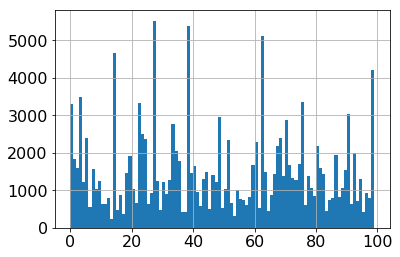

In [36]:
unique_masks2['ClusterId'].hist(bins=unique_masks2['ClusterId'].max());

(100, 768, 768, 3)
(7680, 7680, 3)


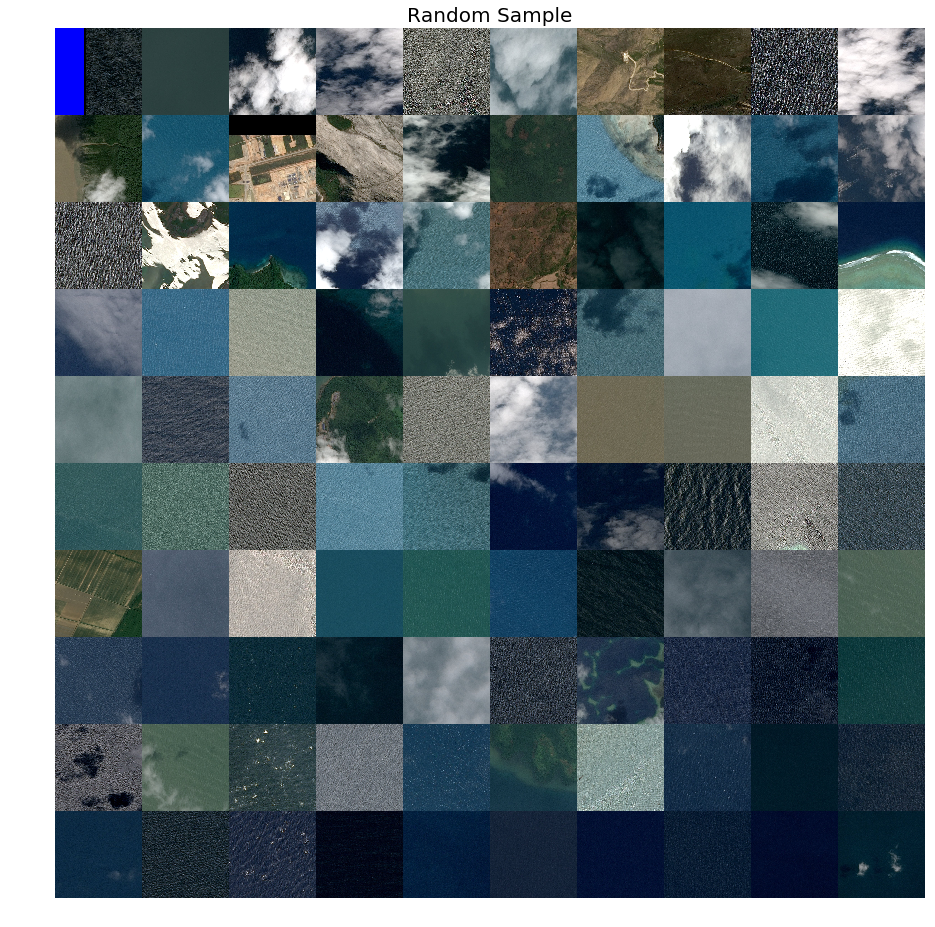

In [41]:
samples_pseudo = np.empty((unique_masks2["ClusterId"].max() + 1, CROP_SIZE, CROP_SIZE, 3), dtype='uint8')
for i, (cluster_id, cluster_size) in enumerate(sorted_bin_sizes):
    sub_idx = np.random.choice(cluster_groups[cluster_id])
    filename = os.path.join(train_chip_dir, img_ids_new[sub_idx])
    in_image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    samples_pseudo[i] = in_image

fig, ax = plt.subplots(1, 1, figsize = (16, 16))
print(samples_pseudo.shape)
batch_rgb = montage_rgb(samples_pseudo)
print(batch_rgb.shape)
ax.imshow(batch_rgb)
ax.set_title('Random Sample')
plt.axis('off')
plt.show()

In [42]:
for j, (cluster_id, cluster_size) in enumerate(sorted_bin_sizes):
    cluster_group = cluster_groups[cluster_id]
    sub_idxs = np.random.choice(cluster_group, 16, replace=False)
    samples_pseudo = np.empty((16, CROP_SIZE, CROP_SIZE, 3), dtype='uint8')
    for i, sub_idx in enumerate(sub_idxs):
        img_id = img_ids_new[sub_idx]
        filename = os.path.join(train_chip_dir, img_id)
#         print(filename)
        samples_pseudo[i] = cv2.imread(filename)

    batch_rgb = montage_rgb(samples_pseudo)
    if batch_rgb.shape[0] > 1920:
        batch_rgb = resize(batch_rgb, (1920, 1920), mode='reflect', anti_aliasing=False)
        batch_rgb = np.array(batch_rgb * 255, dtype=np.uint8)
    cv2.imwrite(
        os.path.join(ship_dir, f"{MASK_METHOD}_{CROP_SIZE}_{j}_{cluster_size}_{cluster_id}.png"), 
        batch_rgb)
    
    if (j + 1) % 10 == 0:
        print(j)

0
10
20
30
40
50
60
70
80
90


In [26]:
unique_masks2.to_csv(chip_file_name, index=False)

In [2]:
unique_masks2 = pd.read_csv(chip_file_name)
print(len(unique_masks2))

149999


In [ ]:
X1 = np.empty((len(temp_list), CROP_SIZE, CROP_SIZE, 3), dtype=np.int16)
X2 = np.empty((len(temp_list), CROP_SIZE, CROP_SIZE, 3), dtype=np.int16)
X12 = np.empty((len(temp_list), CROP_SIZE, CROP_SIZE, 3), dtype=np.int16)
for ii, (img_id1, img_id2, min12, max12) in enumerate(temp_list):
    img1 = cv2.imread(os.path.join(train_chip_dir, img_id1)).astype(np.int16)
    img2 = cv2.imread(os.path.join(train_chip_dir, img_id2)).astype(np.int16)
    X1[ii] = img1
    X2[ii] = img2
    X12[ii] = np.abs(img1 - img2)

In [ ]:
ii = 28
batch_size = 9
for img_id1, img_id2, min12, max12 in temp_list[ii * batch_size: (ii + 1) * batch_size]:
    print(img_id1, file_to_hash[img_id1], min12, max12)
    print(img_id2, file_to_hash[img_id2])
    
# n_samples = (len(temp_list) // batch_size) + 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 20))
ax1.imshow(montage(X1[ii * batch_size: (ii + 1) * batch_size], multichannel=True))
ax1.set_title('Images 1')
ax2.imshow(montage(X2[ii * batch_size: (ii + 1) * batch_size], multichannel=True))
ax2.set_title('Images 2')
ax3.imshow(montage(X12[ii * batch_size: (ii + 1) * batch_size], multichannel=True))
ax3.set_title('Images 12');

### Search similar images.

In [ ]:
#     in_image = cv2.imread(os.path.join(train_chip_dir, c_img_id)).astype(np.int16)
#     in_image_height, in_image_width, _ = in_image.shape


In [ ]:
x1, x2 = 20, 30
y1, y2 = 15, 25
c_img = img[y1:y2,x1:x2]
c_msk = msk[y1:y2,x1:x2]
c_msk_in = msk_in[y1:y2,x1:x2]
c_bnd_in = bnd_in[y1:y2,x1:x2]
c_wht_in = wht_in[y1:y2,x1:x2]
c_bnd_out = bnd_out[y1:y2,x1:x2]
c_wht_out = wht_out[y1:y2,x1:x2]
c_bnd = bnd[y1:y2,x1:x2]
c_wht = wht[y1:y2,x1:x2]
c_wht2 = wht2[y1:y2,x1:x2]
fig, axarr = plt.subplots(3, 3, figsize=(15, 15))
axarr[0][0].imshow(c_msk, extent=[x1, x2, y2, y1])


In [ ]:
from utils import read_stacked_masks
from utils import read_flat_mask

In [ ]:
bad_overlap = [
    'b96a76ee3.jpg', 
    '41243acda.jpg',
    '6f4bac38d.jpg',
    '19dedd4b3.jpg',
    '25b3d35ed.jpg',
    'c3f74eefd.jpg',
    '8432013c3.jpg',
    '41243acda.jpg',
    '461f9e3e6.jpg',
    '6f4bac38d.jpg',
]

In [ ]:
masks[masks['ImageId'] == ImageId]

In [ ]:
print(ImageId)
masks.head()

In [ ]:
ImageId = bad_overlap[9]
img = cv2.cvtColor(cv2.imread(os.path.join(train_image_dir, ImageId)), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
mask_list = read_stacked_masks(ImageId, masks)
all_masks =  np.sum(mask_list, axis=0)

merged_masks = np.zeros((768, 768))
for i, mask in enumerate(mask_list):
    merged_masks += (mask * (i+1))
    
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(merged_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()


In [ ]:
ImageId = '929e28f93.jpg'

img = cv2.imread(os.path.join(train_image_dir, ImageId))
with h5py.File(h5_file, 'r') as mask_h5:
    res = mask_h5[ImageId][:]
    try:
        y_true = mask_h5[ImageId][:] * 1
        print('1', y_true.dtype, y_true.shape)
    except KeyError:
        y_true = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.uint8)
        print('2', y_true.dtype, y_true.shape)

in_mask_list = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

merged_masks = np.zeros((768, 768), dtype=int)
for i, mask in enumerate(in_mask_list):
    merged_masks += (rle_decode(mask) * (i + 1))

bnd = find_boundaries(merged_masks, mode='outer') * 1.0
bnd_in = find_boundaries(merged_masks, mode='inner')
bnd_out = find_boundaries(merged_masks, mode='outer')
bnd_thick = find_boundaries(merged_masks, mode='thick')

msk = all_masks > 0.5
msk_in = msk ^ bnd_in
msk_in2 = msk & ~bnd_thick
wht_in = gaussian(bnd_in, sigma=2)
wht_out = gaussian(bnd_out, sigma=2)
wht_thick = gaussian(bnd_thick, sigma=2)
wht_inout = wht_out + wht_in

print(bnd.shape, np.max(bnd))
wht = gaussian(bnd, sigma=2)

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].imshow(img)
axarr[0].imshow(merged_masks, alpha=0.4)
axarr[1].imshow(bnd_thick)
axarr[2].imshow(wht_thick)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()